In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob

In [7]:
def wrangle(filepath):

    # reading data
    df = pd.read_csv(filepath)
    
    # dropping zero index column
    del df['Unnamed: 0']

    #subsetting data to return apartments only in distrito federal < $100_000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # seperating lat-lon to lat, lon with type float
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)

    # dropping columns with high cardinality, leakage, 50% null values
    df.drop(columns=['operation', 'price', 'currency', 'price_aprox_local_currency', 'expenses', 'lat-lon', 'price_per_m2', 'floor', 'rooms', 'properati_url', 'price_usd_per_m2', 'surface_total_in_m2'], inplace=True)

    # removing outliers
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    mask_area = df['surface_covered_in_m2'].between(low, high)
    df = df[mask_area]

    # subsetting place with parents names
    df['borough'] = df['place_with_parent_names'].str.split('|', expand=True)[1]
    df.drop('place_with_parent_names', axis=1, inplace=True)

    return df

In [8]:
data= wrangle('mexico-city-real-estate-1.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 11 to 4605
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_type          1101 non-null   object 
 1   price_aprox_usd        1101 non-null   float64
 2   surface_covered_in_m2  1101 non-null   float64
 3   lat                    1041 non-null   float64
 4   lon                    1041 non-null   float64
 5   borough                1101 non-null   object 
dtypes: float64(4), object(2)
memory usage: 60.2+ KB


In [10]:
data.head()

,property_type,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,apartment,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,apartment,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,apartment,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,apartment,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,apartment,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [11]:
data.describe()

,price_aprox_usd,surface_covered_in_m2,lat,lon
count,1101.000000,1101.000000,1041.000000,1041.000000
mean,54478.639755,66.792007,19.453685,-99.186423
std,20850.085091,11.579581,0.474031,0.381544
min,7823.940000,48.000000,19.194247,-102.552788
25%,38303.070000,59.000000,19.365533,-99.176540
50%,50947.820000,65.000000,19.399420,-99.147767
75%,68546.690000,75.000000,19.450827,-99.120697
max,99530.030000,91.000000,23.634501,-99.007392


<Axes: ylabel='Frequency'>

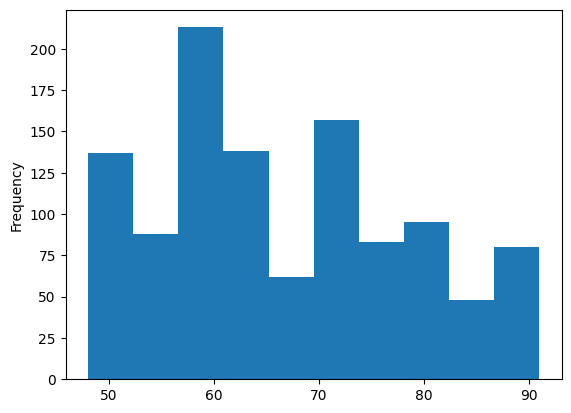

In [12]:
data['surface_covered_in_m2'].plot.hist()

In [13]:
data.isnull().sum()

property_type             0
price_aprox_usd           0
surface_covered_in_m2     0
lat                      60
lon                      60
borough                   0
dtype: int64

In [14]:
files = glob.glob('mexico-city-real-estate-*.csv')

In [15]:
frames = [wrangle(file) for file in files]

In [16]:
df = pd.concat(frames)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 11 to 4618
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_type          5473 non-null   object 
 1   price_aprox_usd        5473 non-null   float64
 2   surface_covered_in_m2  5473 non-null   float64
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
 5   borough                5473 non-null   object 
dtypes: float64(4), object(2)
memory usage: 299.3+ KB


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error

In [19]:
from sklearn.linear_model import LinearRegression, Ridge

In [20]:
#Splitting into features and target
features = ['surface_covered_in_m2', 'lat', 'lon', 'borough']
target = 'price_aprox_usd'

X = df[features]
y = df[target]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [22]:
#building baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

print(f'baseline MAE = {baseline_mae}')

baseline MAE = 17291.3670613654


In [23]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

In [24]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [25]:
predictions = pd.Series(model.predict(X_test))

In [26]:
predictions_mae = mean_absolute_error(y_test, predictions)

print(f'final predictions MAE {predictions_mae}')

final predictions MAE 14748.485370783086


In [27]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names_out()
feat_imp = pd.Series(coefficients, index=features)
feat_imp

surface_covered_in_m2               306.476636
lat                                 955.724362
lon                               -2215.455304
borough_Venustiano Carranza       -5757.738190
borough_Iztapalapa               -12320.107654
borough_Tlalpan                   11408.359104
borough_Xochimilco                 -762.874304
borough_Coyoacán                   2947.157249
borough_Gustavo A. Madero         -5994.705393
borough_Iztacalco                   344.589705
borough_Cuauhtémoc                 -394.315188
borough_Benito Juárez             13996.878464
borough_Álvaro Obregón             3487.807237
borough_Miguel Hidalgo             1909.199128
borough_Azcapotzalco               2378.875647
borough_Tláhuac                  -13585.138440
borough_Cuajimalpa de Morelos      4793.930188
borough_La Magdalena Contreras    -2451.917553
dtype: float64

Text(0.5, 1.0, 'Feature Imporatnce of Apartment Price')

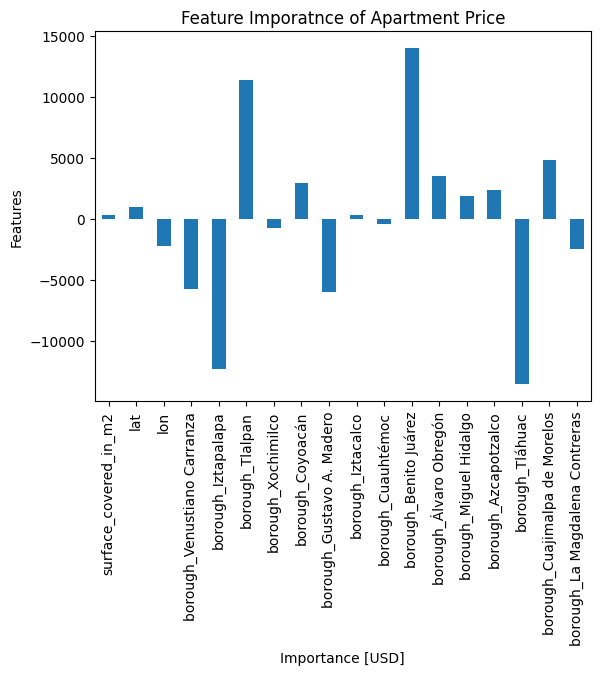

In [28]:
feat_imp.plot.bar()
plt.xlabel('Importance [USD]')
plt.ylabel('Features')
plt.title('Feature Imporatnce of Apartment Price')

In [29]:
from sklearn.ensemble import RandomForestRegressor


model2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=10)
)

In [30]:
model2.fit(X_train, y_train)
predictions2 = model2.predict(X_test)
predictions2_mae = mean_absolute_error(y_test, predictions2)

print(f'MAE for model 2 without hyperparameter tuning is {predictions2_mae}')

MAE for model 2 without hyperparameter tuning is 8419.3206884363


In [31]:
model3 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=200, random_state=1, n_jobs=20)
)

In [32]:
model3.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=200, n_jobs=20,
                                       random_state=1))])

In [35]:
# predictions3 = model3.predict(X_test)
# predictions3_mae = mean_absolute_error(y_test, predictions3)

# print(f'MAE for model 3 with hyperparameter tuning {predictions3_mae}')